# MAT 201A Homework 6
Chengyuan Xu, 18 Spring  

- Read <https://en.wikipedia.org/wiki/Gray_code>

- Download and watch the video named _graycode.mp4_ in the media folder. In your notebook, open this movie using the `cv2.VideoCapture(...)` function and use `imshow` (from matplotlib) to show us the first few frames. Now add some code that counts the number of frame in the video. Print that number.

In [771]:
%pylab inline
# rcParams['figure.figsize'] = (20,10) #wide graphs by default
from __future__ import print_function
from __future__ import division
import cv2
print('OpenCV v' + cv2.__version__)

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

def readGrey(cap):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return ret, frame

Populating the interactive namespace from numpy and matplotlib
OpenCV v3.3.1


### load video file, pick a few images to spot the issues

FPS = 25.0 , total frame count = 2479.0


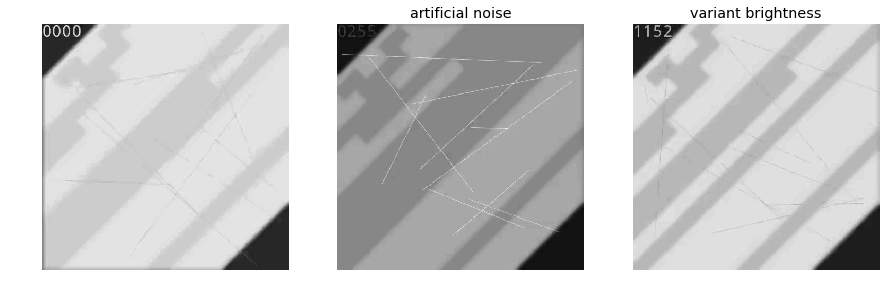

In [772]:
grayCode = '../../fromBox/notebook/media/graycode.mp4'
cap = cv2.VideoCapture(grayCode)

fps = cap.get(cv2.CAP_PROP_FPS)
frameNum = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print("FPS =", fps, ", total frame count =", frameNum)

cap.set(1, 0);
ret, frame = readGrey(cap)
subplot(131)
imshow(frame, cmap='gray')
plt.axis('off')

cap.set(1, 255);
ret, frame = readGrey(cap)
subplot(132)
imshow(frame, cmap='gray')
plt.axis('off')
plt.title('artificial noise')

cap.set(1, 1152);
ret, frame = readGrey(cap)
subplot(133)
imshow(frame, cmap='gray')
plt.axis('off')
plt.title('variant brightness')
pass

- Each frame of the video shows the position of a large rotating wheel where the position is a 16-bit integer encoded using a reflected grey code spread diagonally across the image. Manually decode the position of the wheel for the seventh frame (i.e., the one labeled 0006). Do this in the notebook, showing the image, drawing the diagonal line, and using the `GrayToBinary(...)` function to calculate the position.


### 1. median filter

Text(0.5,1,'median filter')

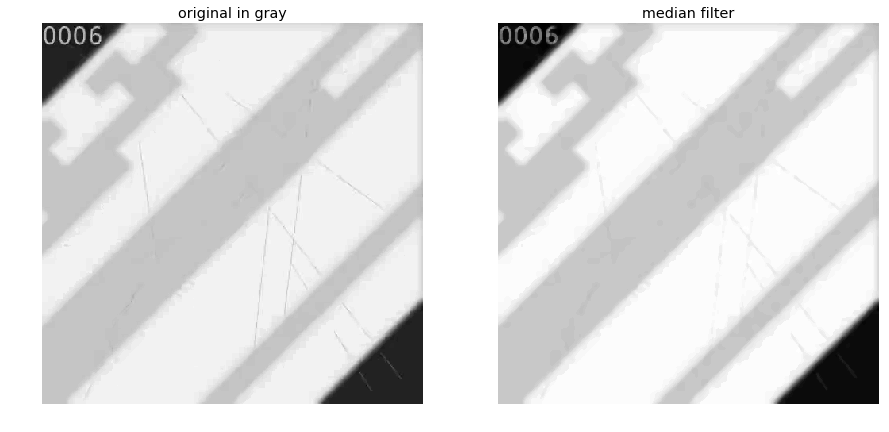

In [781]:
from scipy import ndimage

# decode the first image to get direction

cap.set(1, 6);
ret, frame = readGrey(cap)
subplot(121)
imshow(frame, cmap='gray')
plt.axis('off')
plt.title('original in gray')

# median filter
im_median = ndimage.median_filter(frame, size = 5, mode='nearest')
# im_max = ndimage.maximum_filter(frame, size = 5, mode='nearest')
subplot(122)
imshow(im_median, cmap='gray');
plt.axis('off')
plt.title('median filter')

### 2. closing vs. opening

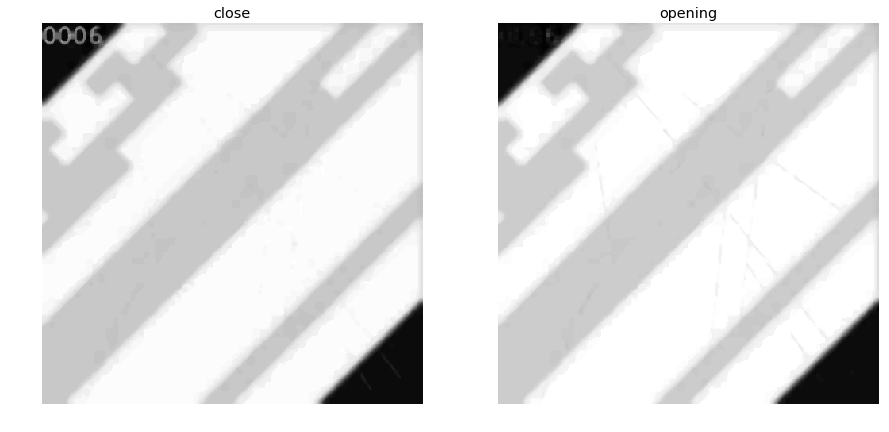

In [782]:
kernel = np.ones((5,5),np.uint8)
im_open = cv2.morphologyEx(im_median, cv2.MORPH_OPEN, kernel)
im_close = cv2.morphologyEx(im_median, cv2.MORPH_CLOSE, kernel)

subplot(121)
imshow(im_close, cmap='gray');
plt.axis('off')
plt.title('close')

subplot(122)
imshow(im_open, cmap='gray');
plt.axis('off')
plt.title('opening');

### 3. thresholding

mean is 84.85158854166667


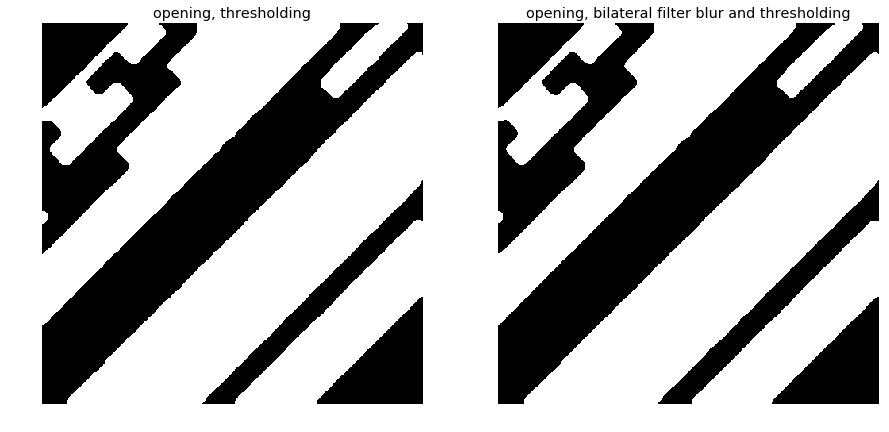

In [784]:
t = mean(im_blur)
print('mean is', t)

ret, im_open_thres = cv2.threshold(im_open, t, 255, cv2.THRESH_BINARY)

subplot(121)
imshow(im_open_thres, cmap='gray');
plt.axis('off')
plt.title('opening, thresholding')

# im_blur = cv2.GaussianBlur(im_open,(5,5), 0)
im_blur = cv2.bilateralFilter(im_open,5,75,75)
ret, im_blur_thres = cv2.threshold(im_blur, t, 255, cv2.THRESH_BINARY)

subplot(122)
imshow(im_blur_thres, cmap='gray');
plt.axis('off')
plt.title('opening, bilateral filter blur and thresholding');

# Otsu's thresholding after Gaussian filtering
# ret3, im_open_thres = cv2.threshold(im_blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# im_open_thres = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
#             cv2.THRESH_BINARY,25,1)

# im_open_thres = cv2.adaptiveThreshold(im_open,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
#             cv2.THRESH_BINARY,9,1)


### 4. rotation & marking information points

Reading succesfully but not sure if accuracy affected by image processing

[0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1]
[1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0]


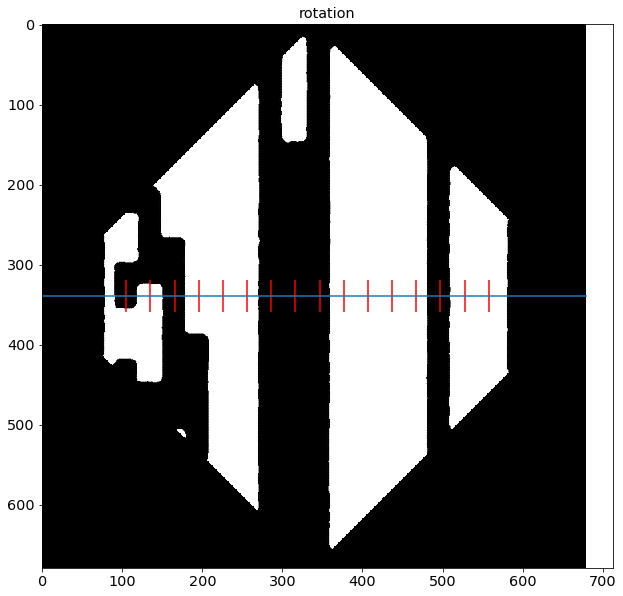

In [796]:
# # histagarm normalization (not used)

# def histeq(im,nbr_bins=256):
#    #get image histogram
#    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
#    cdf = imhist.cumsum() #cumulative distribution function
#    cdf = 255 * cdf / cdf[-1] #normalize
#    #use linear interpolation of cdf to find new pixel values
#    im2 = np.interp(im.flatten(),bins[:-1],cdf)
#    return im2.reshape(im.shape), cdf

# im_norm, cdf = histeq(im_blur_thres, 256)

# roatation
im_rotate = ndimage.rotate(im_blur_thres, 45, mode='constant')

# length, half-height, and seperation
l = len(im_rotate)
h = 0.5 * l
s = l / 22.5

# mark the data points
imshow(im_rotate, cmap='gray')
plt.plot([0, l], [h, h])
plt.vlines([105 + x * s for x in range(16)], h-20, h+20, 'r')
plt.title('rotation');

# read the data points
x_pos = np.array([105+ s * x for x in range(16)]).astype(int)
im_rotate[int(h), x_pos].tolist()

forward = im_rotate[int(h), x_pos]
forward = where(forward > 128, 1 , 0)

backward = im_rotate[int(h), x_pos][::-1]
backward = where(backward > 128, 1 , 0)

print('Reading succesfully but not sure if accuracy affected by image processing\n')
print(forward)
print(backward)

### define generic functions for later

In [786]:
def BinaryToGray(num):
    return num ^ (num >> 1)

def GrayToBinary(num):
    num = num ^ (num >> 16)
    num = num ^ (num >> 8)
    num = num ^ (num >> 4)
    num = num ^ (num >> 2)
    num = num ^ (num >> 1)
    return num

def toint(b):
    total = 0
    for n in range(len(b)):
        total = total + 2**n * b[len(b) - 1 - n]
    return total

### find out what order should we interpretate data

In [791]:
print(backward)
int_backward = toint(backward)
print(int_backward)
bb = GrayToBinary(int_backward)
print(bb)

print(forward)
int_forward = toint(forward)
print(int_forward)
bb = GrayToBinary(int_forward)
print(bb)

# print(int_forward)

# aa = bin(int_forward)[2:]
# aa = int(aa)
# print(aa)

# bb = GrayToBinary(aa)
# print(bb)

# frame0_binary_forward = fromstring(frame0_binary_forward,dtype=int)
# # np.fromstring('1 2', , sep=' ')
# print(frame0_binary_forward)

# type(frame0_binary_forward)

# frame0_gray_int = BinaryToGray(frame0_binary_forward)
# print(frame0_gray_int)


# frame0_gray = GrayToBinary(frame0_binary_forward)
# print(frame0)
# print(frame0_gray)

# firstNum = bin(16000)[2:]
# print(firstNum)
# firstNum = int(firstNum)
# firstNum = BinaryToGray(16000)

# print(firstNum)
# start image of the disc
# position (converted)
# 16,000

[1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0]
56890
37932
[0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1]
23675
26706


- Watch the video again; This time, occasionally pause and make note of all the problems. Imagine that you had to write a program to calculate the position of the wheel for each frame of video. Characterize each phenomenon that might pose an obstacle to such a program, showing evidence of each in your notebook. Think: what aspects of the video are _not_ the data that encodes the position of the wheel?

- Make a list of image transformations that we might use to clean, fix, reorganize, reconstitute, and _extract_ the data we need to decode the position of the wheel for any given frame. Name and describe each of these proposed transformations.

**I believe my implementation earlier has answered most of these questions.**

- Write a program that calculates the position of the wheel for each frame of the video. Plot the data with the frame number on the x axis and estimated position on the y axis.


** All-in-one implementaion **

In [780]:
# input is one image from cv2.VideoCapture()
# use this func in a for loop

import cv2
from scipy import ndimage

def img2bin(im):
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_median = ndimage.median_filter(im_gray, size = 5, mode='nearest')
    im_open = cv2.morphologyEx(im_median, cv2.MORPH_OPEN, kernel)
    im_blur = cv2.bilateralFilter(im_open,5,75,75)
    ret, im_blur_thres = cv2.threshold(im_blur, t, 255, cv2.THRESH_BINARY)
    im_rotate = ndimage.rotate(im_blur_thres, 45, mode='constant')

    # read the data points
    l = len(im_rotate)
    h = 0.5 * l - 5
    s = l / 22.5
    x_pos = np.array([100 + s * x for x in range(16)]).astype(int)
    im_rotate[int(h), x_pos].tolist()

    forward = im_rotate[int(h), x_pos]
    forward = where(forward > 128, 1 , 0)

    backward = im_rotate[int(h), x_pos][::-1]
    backward = where(backward > 128, 1 , 0)
    
    return backward    

In [ ]:
def vid2bin(vid):
    cap = cv2.VideoCapture(vid)
    ret, frame = cap.read()
    code = array(img2bin(frame))
    while True:
        code = np.vstack((code, img2bin(frame)))
        ret, frame = cap.read()
        if not cap.read():
            break
    return code

In [ ]:
# test
grayCode = '../../fromBox/notebook/media/graycode.mp4'
vid2bin(grayCode)

In [ ]:
print(code)